In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import tensorflow as tf
import numpy as np
from common import create_toy_regression_dataset, plot_regression_model_analysis
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential


In [2]:
def gaussian_nll(y_true, y_pred):
    """
    Gaussian negative log likelihood
    
    Note: to make training more stable, we optimize
    a modified loss by having our model predict log(sigma^2)
    rather than sigma^2. 
    """
    
    y_true = tf.reshape(y_true, [-1])
    mu = y_pred[:, 0]
    si = y_pred[:, 1]
    loss = (si + tf.square(y_true - mu)/tf.math.exp(si)) / 2.0
    return tf.reduce_mean(loss)

def define():
    model = Sequential([
        Dense(10, activation='relu'),
        Dense(10, activation='tanh'),
        Dropout(.5),
        Dense(2, activation=None)
    ])
    optim = tf.keras.optimizers.Adam(1e-3)
    model.compile(opitimizer=optim, loss=gaussian_nll)
    return model

def train(x, y, model, epochs=100):
    model.fit(x, y, batch_size=32, epochs=epochs, verbose=0)
    return model

def predict(models, x):
    '''
    Args:
        models: The trained keras model ensemble
        x: the input tensor with shape [N, M]
        samples: the number of monte carlo samples to collect
    Returns:
        y_mean: The expected value of our prediction
        y_std: The standard deviation of our prediction
    '''
    mu_arr = []
    si_arr = []

    for model in models:
        y_pred = model(x)
        mu = y_pred[:, 0]
        si = y_pred[:, 1]

        mu_arr.append(mu)
        si_arr.append(si)

    mu_arr = np.array(mu_arr)
    si_arr = np.array(si_arr)
    var_arr = np.exp(si_arr)

    y_mean = np.mean(mu_arr, axis=0)
    y_variance = np.mean(var_arr + mu_arr**2, axis=0) - y_mean**2
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

In [3]:
xmin = -10.
xmax = 10.

data = create_toy_regression_dataset(xmin=xmin, xmax=xmax, noise_std=.2)
x_gt = data[0]
y_gt = data[1]
x_trn = data[2]
y_trn = data[3]
x_tst = data[4]
y_tst = data[5]

models = [define() for i in range(5)]
models = [train(x_trn[:, np.newaxis], y_trn[:, np.newaxis], model) for model in models]

In [4]:
yhat_mean, yhat_std = predict(models, x_tst[:, np.newaxis])

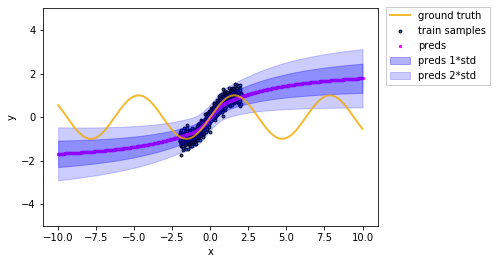

In [7]:
plot_regression_model_analysis(gt=(x_gt, y_gt),
                               trn=(x_trn, y_trn),
                               pred=(x_tst, yhat_mean, yhat_std),
                               xlim=(-11, 11),
                               ylim=(-5, 5))
plt.savefig('fig.svg', bbox_inches='tight')